# [CDAF] Atividade 5

## Nome e matrícula
Nome: Júlio Guerra Domingues
Matrícula: 2022431280

Nome: Leandro Luiz Duarte Teixeira
Matrícula: 2024006099

## Referências
- [1] https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
- [2] https://github.com/metrica-sports/sample-data

## Introdução
Nessa atividade vamos abrir, manipular e fazer algumas análises com os dados de tracking

## Carregando os dados

Acesse [2] e baixe os arquivos do repositório em formato ZIP.

Depois extraia os arquivos pra uma pasta local.

Substitua o caminho da pasta com os jogos de amostra no código abaixo.

In [1]:
!git clone https://github.com/metrica-sports/sample-data.git
!git clone https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking.git

fatal: destination path 'sample-data' already exists and is not an empty directory.
fatal: destination path 'LaurieOnTracking' already exists and is not an empty directory.


## Parte 1

Escolha um dos jogos disponíveis na pasta. Repare que os dados estão anonimizados, então não é possível saber quem são os times e jogadores envolvidos.

In [2]:
game_id = 2

Utilizando os códigos disponíveis em [1] e o tutorial "Tutorial1_GettingStarted.py", carregue os dados de evento e os frames de tracking das duas equipes envolvidas no jogo escolhido.

Em seguida, faça um plot de um evento de gol ou finalização, acrescentando a posição dos jogadores sem bola de ambas as equipes.

In [3]:
import sys
sys.path.append('/content/LaurieOnTracking')

In [4]:
import Metrica_IO as mio
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv
import Metrica_IO as mio

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.animation as animation


In [15]:


def calc_player_velocities(team, smoothing=True, filter_='Savitzky-Golay', window=7, polyorder=1, maxspeed = 12):
    """ calc_player_velocities( tracking_data )

    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data

    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN.

    Returrns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added

    """
    # remove any velocity data already in the dataframe
    team = mvel.remove_player_velocities(team)

    # Get the player ids
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home','Away'] ] )

    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()

    # index of first frame in second half
    second_half_idx = team.Period.idxmax()

    # estimate velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[ raw_speed>maxspeed ] = np.nan
            vy[ raw_speed>maxspeed ] = np.nan

        if smoothing:
            if filter_=='Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            elif filter_=='moving average':
                ma_window = np.ones( window ) / window
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx] , ma_window, mode='same' )
                vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx] , ma_window, mode='same' )
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:] , ma_window, mode='same' )
                vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:] , ma_window, mode='same' )


        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt( vx**2 + vy**2 )

    return team

In [6]:

def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )

    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.

    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)

    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    if figax is None: # create new pitch
        fig,ax = mviz.plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ]
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', markersize=6, alpha=1.0, linewidth=0)
    return fig,ax


In [7]:
def to_single_playing_direction(home,away,events):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home,away,events]:
        second_half_idx = team.Period.idxmax()
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx:,columns] *= -1
    return home,away,events

In [8]:
sys.path.append('/content/sample-data/data')
DATADIR = '/content/sample-data/data'

In [9]:
import Metrica_Viz as mviz
import Metrica_IO as mio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

events = mio.read_event_data(DATADIR,game_id)
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

events = mio.to_metric_coordinates(events)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']

home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

Reading team: home
Reading team: away


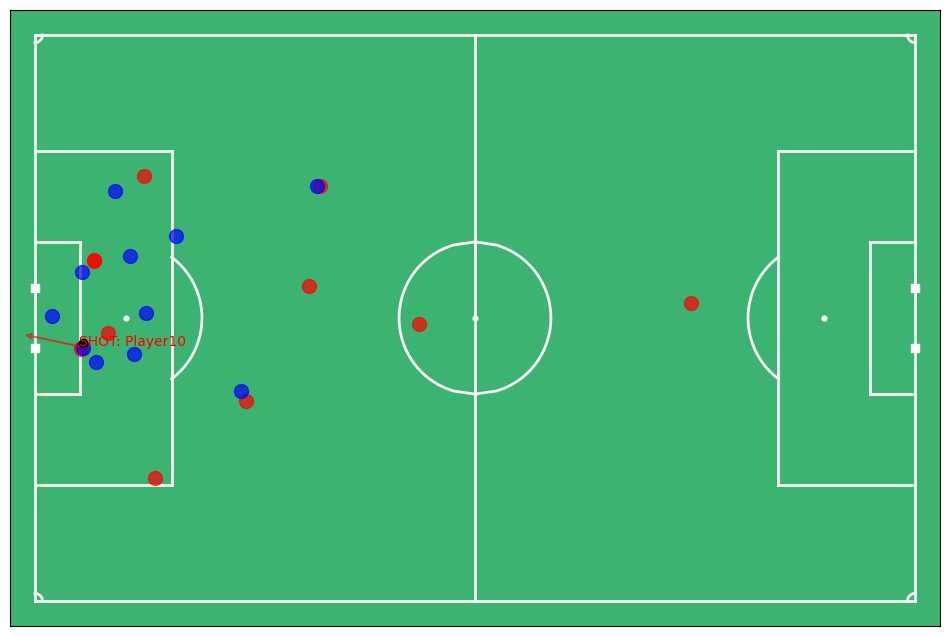

In [10]:
fig,ax = mviz.plot_events(home_goals.iloc[0:1], indicators = ['Marker','Arrow'], annotate=True )
goal_frame = home_goals.iloc[0]['Start Frame']
fig,ax = plot_frame(tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax))

Agora faça um plot descrevendo a trajetória do jogador que finalizou considerando os 1500 frames anteriores ao gol/finalização

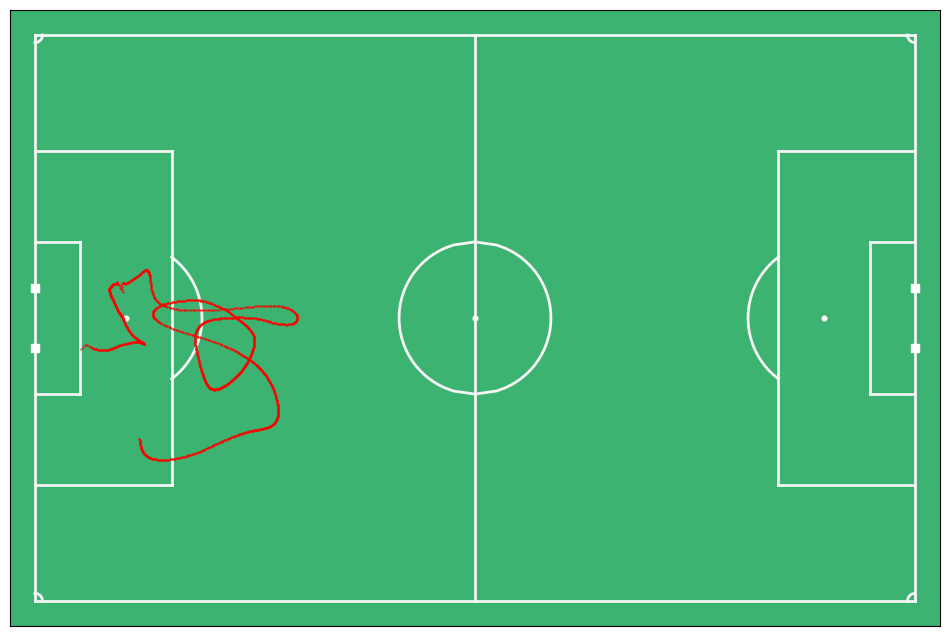

In [11]:
fig,ax = mviz.plot_pitch()
ax.plot( tracking_home['Home_10_x'].iloc[goal_frame-1500:goal_frame], tracking_home['Home_10_y'].iloc[goal_frame-1500:goal_frame], 'r.', markersize=1)
plt.show()

## Parte 2

Utilize o código de "Tutorial2_DelvingDeeper.py" para calcular as velocidades dos jogadores em cada frame. Em seguida faça o plot de um frame qualquer incluindo vetores de velocidade.

Reading team: home
Reading team: away


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

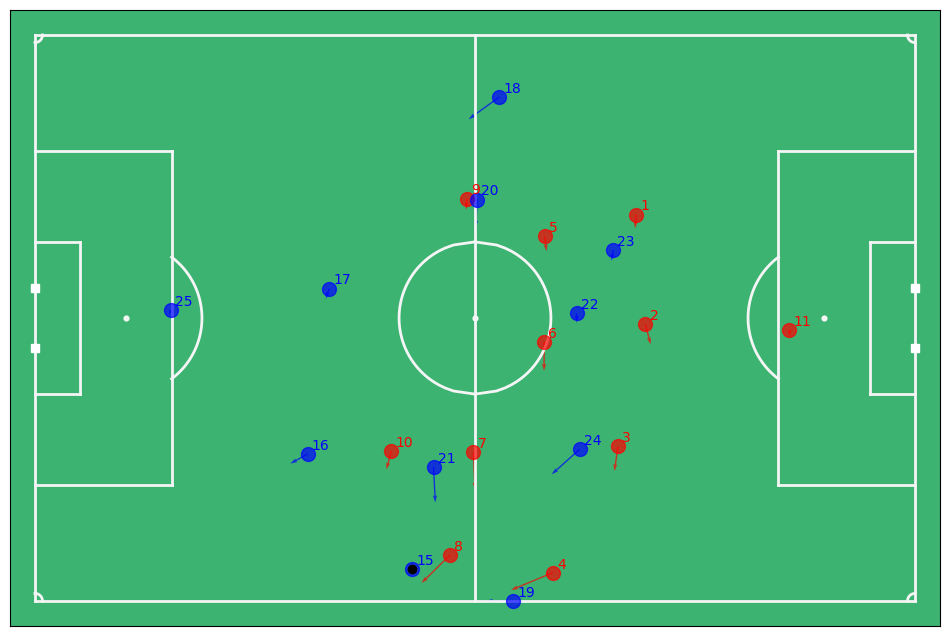

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 13 11:34:26 2020

Script for lesson 5 of "Friends of Tracking" #FoT

Data can be found at: https://github.com/metrica-sports/sample-data

Accompanying video tutorials can be found here: https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w

GitHub repo: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

@author: Laurie Shaw (@EightyFivePoint)
"""



import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = calc_player_velocities(tracking_home,smoothing=True)
tracking_away = calc_player_velocities(tracking_away,smoothing=True)

plot_frame( tracking_home.loc[2345], tracking_away.loc[2345], include_player_velocities=True, annotate=True)

Crie um resumo físico para os jogadores envolvidos na partida. Plote as distâncias percorridas por cada jogador em cada ritmo (walking, jogging, running, sprinting)

Você consegue dizer a partir desse resumo quais jogadores são os goleiros?

In [40]:
# Create a Physical summary dataframe for away players
away_players = np.unique( [ c.split('_')[1] for c in tracking_away.columns if c[:4] == 'Away' ] )
away_summary = pd.DataFrame(index=away_players)

# Calculate minutes played for each player
minutes = []
for player in away_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Away_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_away[column].last_valid_index() - tracking_away[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
away_summary['Minutes Played'] = minutes
away_summary = away_summary.sort_values(['Minutes Played'], ascending=False)

# Calculate total distance covered for each player
distance = []
for player in away_summary.index:
    column = 'Away_' + player + '_speed'
    player_distance = tracking_away[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
away_summary['Distance [km]'] = distance

# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in away_summary.index:
    column = 'Away_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_away.loc[tracking_away[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_away.loc[ (tracking_away[column] >= 2) & (tracking_away[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_away.loc[ (tracking_away[column] >= 4) & (tracking_away[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_away.loc[ tracking_away[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )

away_summary['Walking [km]'] = walking
away_summary['Jogging [km]'] = jogging
away_summary['Running [km]'] = running
away_summary['Sprinting [km]'] = sprinting

In [41]:
# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

# Calculate minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

# Calculate total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )

home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting


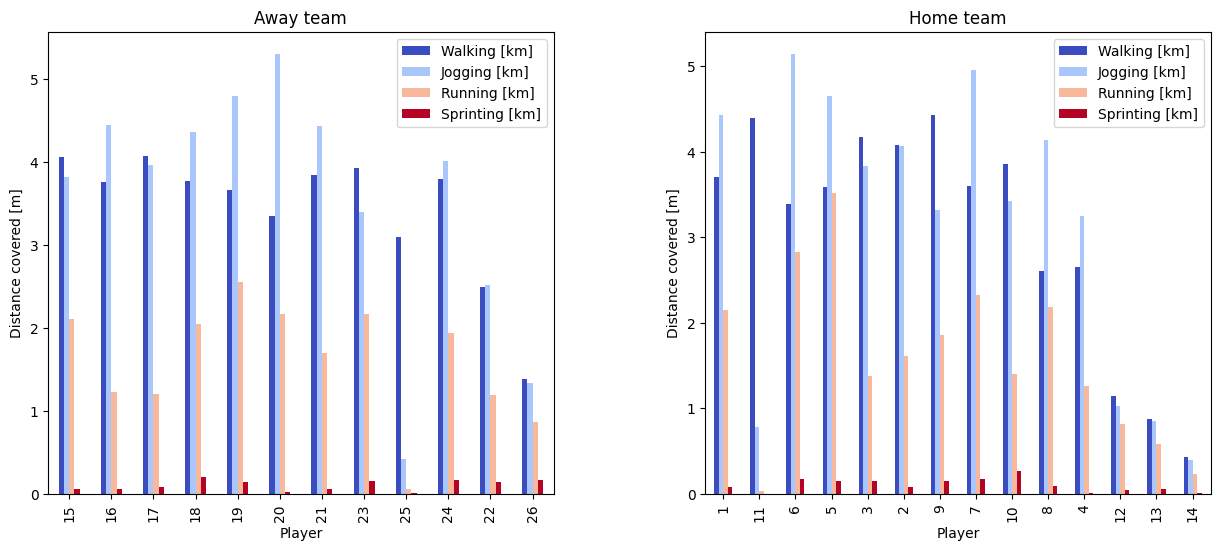

In [42]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # Create two subplots side by side
fig.subplots_adjust(wspace=0.3) # Add space between subplots


away_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(ax=ax1, colormap='coolwarm')
ax1.set_xlabel('Player')
ax1.set_ylabel('Distance covered [m]')
ax1.set_title('Away team')

home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(ax=ax2, colormap='coolwarm')
ax2.set_xlabel('Player')
ax2.set_ylabel('Distance covered [m]')
ax2.set_title('Home team')

plt.show()


Os goleiros são os jogadores com maior discrepância entre a distância caminhada e a distância correndo (números 25 e 11, respectivamente).

Por fim, escolha um jogador e faça um plot com seus sprints no campo

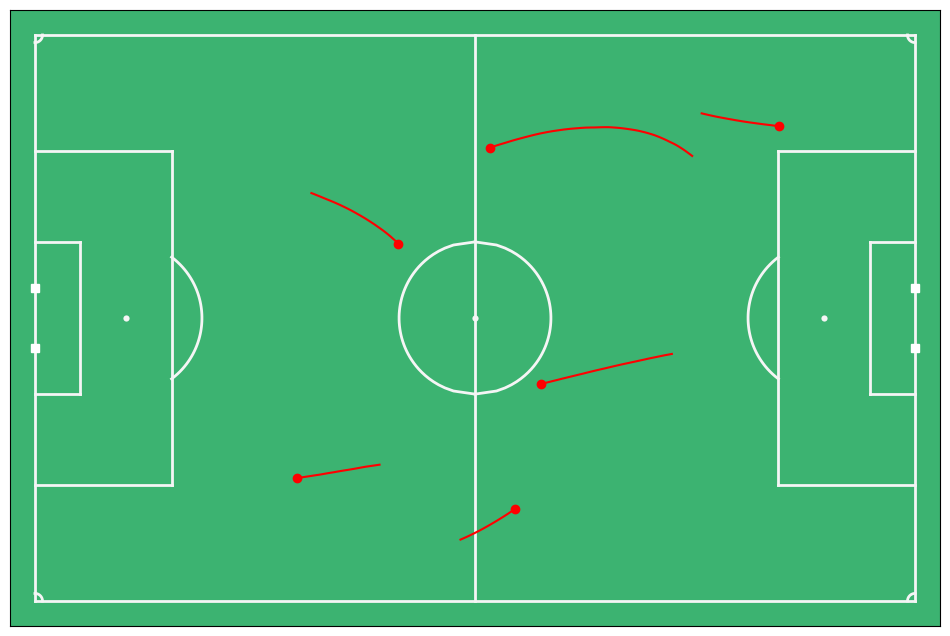

In [39]:
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

# Plot the trajectories for each of player 10's sprints
player = '8'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position
# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
# now plot all the sprints
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro')
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')
